# Human activity recognition data set
- Using DTW to cluster
- TSFRESH to engineer basic features
- Random forest to predict DTW clusters
- Compare proximity matrix of random forest with DTW matrix

Data is from here https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones#

**TODO**

- Add some exposition
- Try to find clusters that aren't so imbalanced
 - Look into why clustering is not separating two sections when $k=2$

In [527]:
from IPython.core.display import display, HTML, Javascript
display(HTML("<style>.container { width:90% !important; }</style>"))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json
import networkx as nx

from sklearn import metrics
from seaborn import heatmap
from sklearn.calibration import calibration_curve

# format notebook output
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# style pandas display
pd.set_option('display.max_columns', None)

# matplotlib magic
%matplotlib inline

In [528]:
def clf_eval_viz(clf_name, y_test, clf_preds, clf_probs):
    
    # generate classification report
    print("accuracy = " + str(metrics.accuracy_score(y_test, clf_preds, normalize=True)))
    print("brier = " + str(metrics.brier_score_loss(y_test, clf_probs, pos_label=y_test.max())))
    print('MCC = ' + str(metrics.matthews_corrcoef(y_test, clf_preds)))
    print(metrics.classification_report(y_test, clf_preds))
    
    # create subplot
    plt.figure(figsize=(7, 12))
    ax1 = plt.subplot2grid((4,4), (0,0), colspan=2)
    ax2 = plt.subplot2grid((4,4), (0,2), colspan=2)
    ax3 = plt.subplot2grid((4,4), (1, 0), colspan=4)
    ax4 = plt.subplot2grid((4,4), (2, 0), colspan=4)
    
    # create confusion matrix
    ax1.set_title("Confusion Matrix", fontsize=14)
    cm = metrics.confusion_matrix(y_test, clf_preds)
    heatmap(cm, annot=True, fmt='', cmap='Blues', ax=ax1)
    ax1.set_xlabel('Predicted label')
    ax1.set_ylabel('Actual label')
    
    # create roc curve
    ax2.set_title("ROC Curve", fontsize=14)
    fpr, tpr, _ = metrics.roc_curve(y_test, clf_probs)
    area = metrics.auc(fpr, tpr)
    ax2.plot(fpr, tpr, label=clf_name+' (area = %0.2f)' % area, linewidth=3)
    ax2.plot([0, 1], [0, 1], 'k--')
    ax2.set_xlabel('False positive rate')
    ax2.set_ylabel('True positive rate')
    ax2.legend(loc="lower right")
    
    # calculate fraction of positives and mean predicted value
    fop, mpv = calibration_curve(y_test, clf_probs, n_bins=10)
    
    # create calibration plot 1
    ax3.plot(mpv, fop, "s-", label="%s" % (clf_name, ))
    ax3.set_ylabel("Fraction of positives")
    ax3.set_ylim([-0.05, 1.05])
    ax3.legend(loc="lower right")
    ax3.set_title('Calibration Plots (Reliability Curve)', fontsize=14)
    # create calibration plot 2
    ax4.hist(clf_probs, range=(0, 1), bins=10, label=clf_name, histtype="step", lw=2)
    ax4.set_xlabel("Mean predicted value")
    ax4.set_ylabel("Count")
    ax4.legend(loc="upper center", ncol=2)
    
    # format subplot
    plt.tight_layout()

# Get data

In [717]:
with open('/Users/eric.bunch/Downloads/UCI HAR Dataset/train/X_train.txt', 'r') as f:
    X_train = f.read()

with open('/Users/eric.bunch/Downloads/UCI HAR Dataset/train/y_train.txt', 'r') as f:
    y_train = f.read()

In [718]:
X_train = X_train.split('\n')[:-1] # end of file is double new line
y_train = y_train.split('\n')[:-1]

In [719]:
len(X_train)
len(y_train)

7352

7352

In [720]:
set(y_train)

{'1', '2', '3', '4', '5', '6'}

In [721]:
len_y_train = len(y_train)

data_train = {
    i: {
        'series': pd.Series(list(filter(lambda x: x != '', X_train[i].split(' ')))).astype(float),
        'label': int(y_train[i])
    }
    for i in range(len_y_train)
}

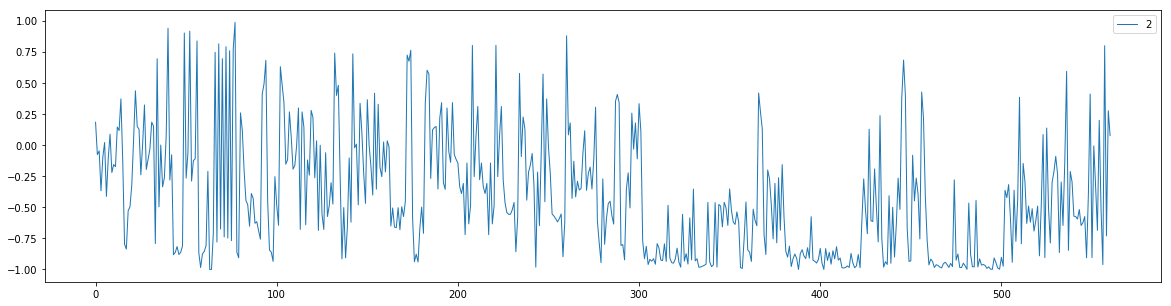

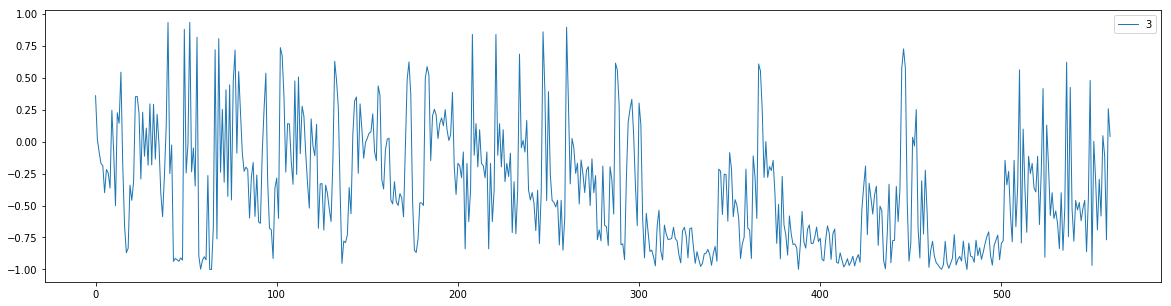

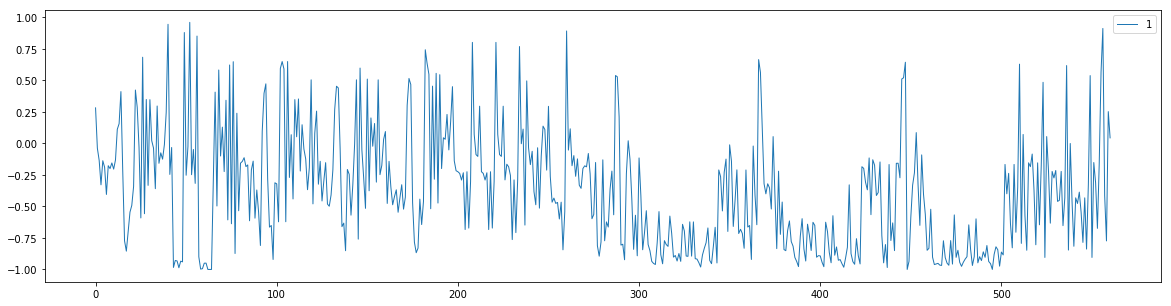

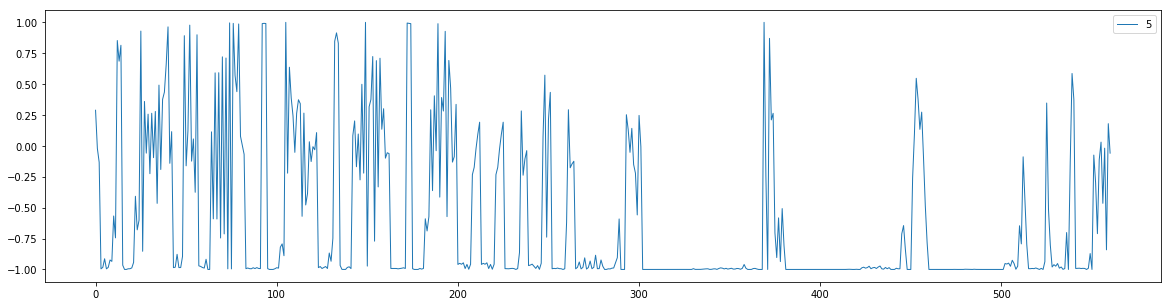

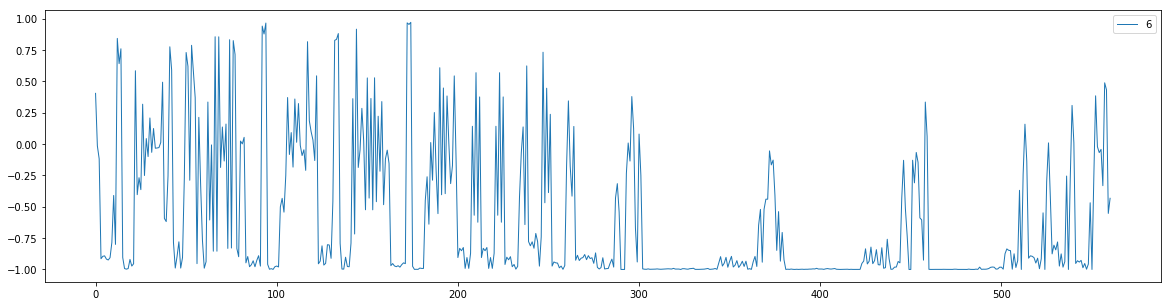

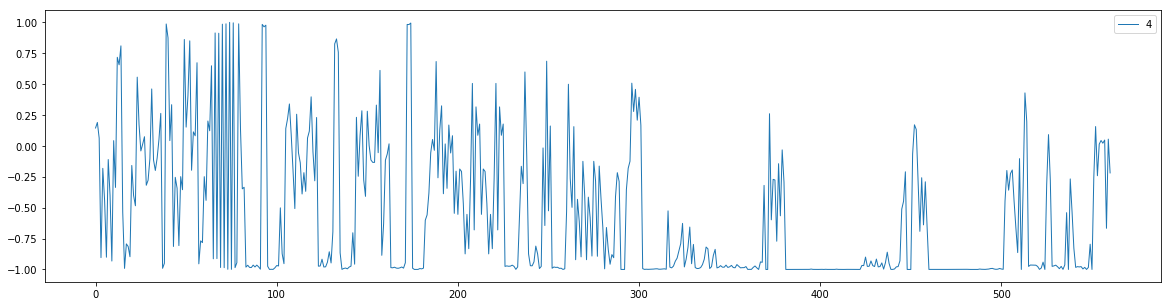

In [722]:
# plot sample time series from each class label

for label in set(y_train):
    # get first occurrence of time series with this cluster label
    index = y_train.index(label)
    data_train[index]['series'].to_frame(name=label).plot(
        kind='line',
        lw=1,
        figsize=(20, 5)
    );

plt.show();

# Dynamic time warping

Using `dtaidistance` library https://github.com/wannesm/dtaidistance.

Install the DTW library from github repository through the following command

```
$ pip install git+https://github.com/wannesm/dtaidistance.git#egg=dtaidistance
```

This can be found in the docs page http://dtaidistance.readthedocs.io/en/latest/usage/installation.html

In [723]:
from dtaidistance import dtw

In [724]:
n_series = 500

In [725]:
srs = [np.array(data_train[key]['series'], dtype=np.double) for key in list(data_train.keys())[:n_series]]

In [726]:
%%time

dtw_mtx = dtw.distance_matrix_fast(
    srs,
    max_dist=None,
    max_length_diff=None,
    max_step=30,
    penalty=0.1,
    psi=7,
    parallel=True
)

CPU times: user 2min 55s, sys: 3.74 s, total: 2min 59s
Wall time: 2min 53s


In [727]:
dtw_mtx[dtw_mtx == np.inf] = 0
dtw_mtx = dtw_mtx+dtw_mtx.T

In [728]:
# normalize distance matrix

dtw_mtx = dtw_mtx/dtw_mtx.max()

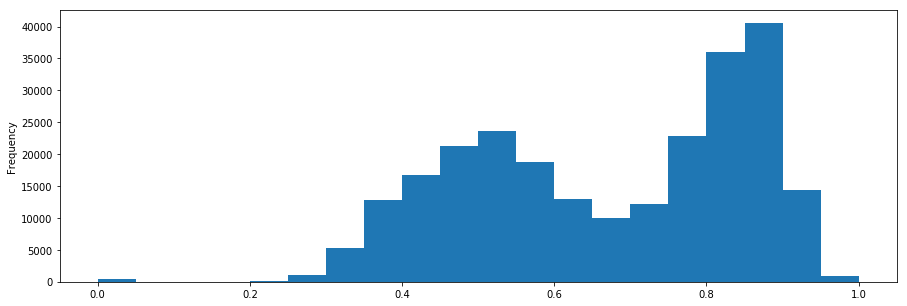

In [729]:
pd.Series(dtw_mtx.flatten()).plot(
    kind='hist',
    figsize=(15, 5),
    bins=20
);

## KNN with DTW matrix as classifier

In [730]:
from sklearn.neighbors import DistanceMetric, KNeighborsClassifier
from sklearn.model_selection import train_test_split

In [731]:
def dtw_distance_function(x, y):
    # x and y must be one-dimensional numpy arrays
    # in our case they will each be one-dimensional, representing a point's index
    return dtw_mtx[int(x[0]), int(y[0])]

In [732]:
metric = DistanceMetric.get_metric('pyfunc', func=dtw_distance_function)

In [733]:
X_nn = pd.Series([np.array([idx]) for idx in range(len(dtw_mtx))])
y_nn = pd.Series(y_train[:n_series])

X_train_nn, X_test_nn, y_train_nn, y_test_nn = train_test_split(
    X_nn,
    y_nn,
    test_size=0.3,
    random_state=42
)

In [845]:
kneighbors = KNeighborsClassifier(
    n_neighbors=30,
    weights='distance',
    metric=dtw_distance_function
)

In [846]:
kneighbors.fit(X_train_nn.values.reshape(-1, 1), y_train_nn)

KNeighborsClassifier(algorithm='auto', leaf_size=30,
           metric=<function dtw_distance_function at 0x1c2eff66a8>,
           metric_params=None, n_jobs=1, n_neighbors=30, p=2,
           weights='distance')

In [847]:
kneighbors.score(X_test_nn.values.reshape(-1, 1), y_test_nn)

0.92000000000000004

In [848]:
predictions_nn = kneighbors.predict(X_test_nn.values.reshape(-1, 1))

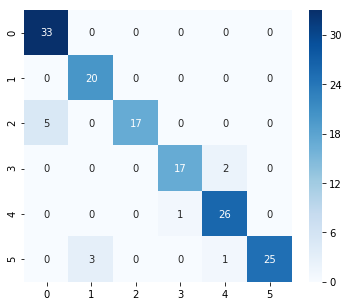

In [849]:
fig, ax = plt.subplots(figsize=(6, 5));

sns.heatmap(
    data=confusion_matrix(y_true=y_test_nn, y_pred=predictions_nn),
    annot=True,
    cmap='Blues',
    ax=ax
);

# Spectral clustering

## Nearest neighbors graph

In [850]:
metric = DistanceMetric.get_metric('pyfunc', func=dtw_distance_function)

In [851]:
X_nn = pd.Series([np.array([idx]) for idx in range(len(dtw_mtx))])

In [857]:
from sklearn.neighbors import NearestNeighbors

nnb = NearestNeighbors(
    n_neighbors=30,
    metric=dtw_distance_function
)

nnb.fit(X_nn.values.reshape(-1, 1))

NearestNeighbors(algorithm='auto', leaf_size=30,
         metric=<function dtw_distance_function at 0x1c2eff66a8>,
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0)

In [858]:
def get_kgneighbors_indexes(idx):
#     return nnb.kneighbors(dtw_mtx[[idx]])[1][0]
    return nnb.kneighbors(X_nn[[idx]].values.reshape(-1, 1))[1][0]

In [895]:
from functools import reduce

knn_edges = reduce(lambda x, y: x+y, [
    [(idx, neighbor_idx.item()) for neighbor_idx in get_kgneighbors_indexes(idx) if idx != neighbor_idx]
    for idx in range(len(dtw_mtx))
])

# mutual k-neighbors graph
knn_edges_both = [
    e for e in knn_edges if (e[1], e[0]) in knn_edges and e[0] < e[1]
]

G = nx.Graph()

G.add_nodes_from(list(range(len(dtw_mtx))))

G.add_edges_from(knn_edges_both)

nodes = [{'name': str(i), 'cluster': str(y_nn[i])} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('har_dtw_distance_neighbors_graph.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

### Graph labeled with *actual labels* from data set

In [896]:
%%html
<div id="har_dtw_distance_neighbors_graph"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [897]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-20)
    .linkDistance(25)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#har_dtw_distance_neighbors_graph").select("svg")
  if (svg.empty()) {
    svg = d3.select("#har_dtw_distance_neighbors_graph").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("har_dtw_distance_neighbors_graph.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 3)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.cluster);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

### Eigenvalue decomposition and clustering

In [816]:
from numpy.linalg import eig
from sklearn.cluster import KMeans

In [860]:
knn_adjacency = np.zeros(shape=(len(dtw_mtx), len(dtw_mtx)))

In [861]:
for (i, j) in knn_edges_both:
    knn_adjacency[i][j] = 1
    knn_adjacency[j][i] = 1

In [862]:
knn_normalized_laplacian = \
np.identity(n=len(dtw_mtx)) - \
(np.linalg.inv(np.diag(dtw_mtx.sum(axis=0)))@knn_adjacency)

In [863]:
w, v = eig(knn_normalized_laplacian)

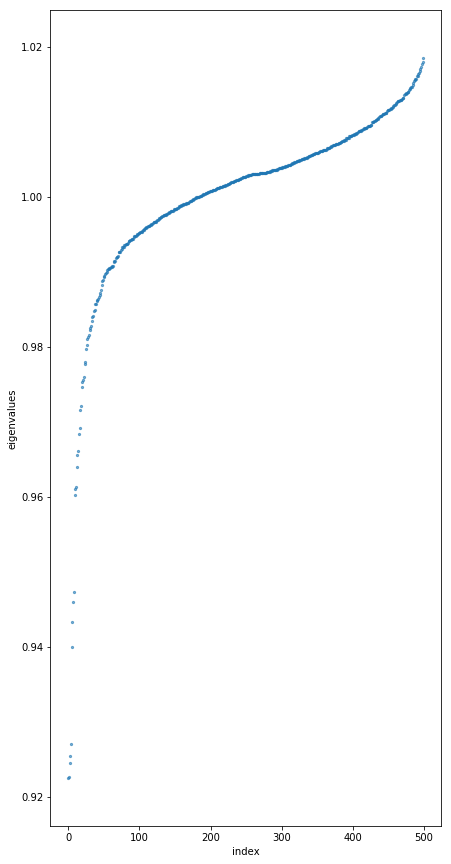

In [864]:
# eigenvalue plot

pd.DataFrame(sorted(w)).reset_index().rename(columns={0: 'eigenvalues'}).plot(
    kind='scatter',
    x='index',
    y='eigenvalues',
    figsize=(7, 15),
    s=5,
    alpha=0.6
);

In [901]:
n_clusters = 20

In [902]:
evals_idx_list = [list(w).index(sorted(w)[idx]) for idx in range(n_clusters)]
evals_idx_list

[0, 5, 1, 7, 6, 8, 2, 9, 3, 15, 16, 4, 18, 20, 10, 11, 21, 12, 13, 14]

In [903]:
kmeans = KMeans(
    n_clusters=n_clusters,
    random_state=42
)

knn_clusters = kmeans.fit_predict(v[:,evals_idx_list])

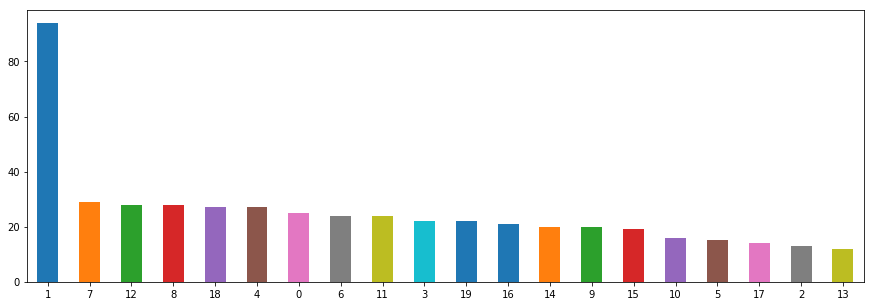

In [904]:
pd.Series(knn_clusters).value_counts().plot(
    kind='bar',
    figsize=(15, 5),
    rot=0
);

In [905]:
from functools import reduce

knn_edges = reduce(lambda x, y: x+y, [
    [(idx, neighbor_idx.item()) for neighbor_idx in get_kgneighbors_indexes(idx) if idx != neighbor_idx]
    for idx in range(len(dtw_mtx))
])

# mutual k-neighbors graph
knn_edges_both = [
    e for e in knn_edges if (e[1], e[0]) in knn_edges and e[0] < e[1]
]

G = nx.Graph()

G.add_nodes_from(list(range(len(dtw_mtx))))

G.add_edges_from(knn_edges_both)

nodes = [{'name': str(i), 'cluster': str(knn_clusters[i].item())} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('har_dtw_distance_neighbors_graph_clusters.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

### Graph labeled with *cluster labels*

In [906]:
%%html
<div id="har_dtw_distance_neighbors_graph_clusters"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [907]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-20)
    .linkDistance(25)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#har_dtw_distance_neighbors_graph_clusters").select("svg")
  if (svg.empty()) {
    svg = d3.select("#har_dtw_distance_neighbors_graph_clusters").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("har_dtw_distance_neighbors_graph_clusters.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 3)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.cluster);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>

## Comparison with activity labels

In [908]:
truncated_confusion_mtx = confusion_matrix(
    y_test_nn.astype(int),
    knn_clusters[y_test_nn.index]
)[np.array(sorted((y_test_nn.astype(int).unique()))),]

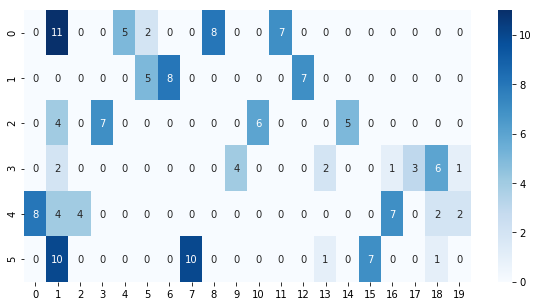

In [912]:
fig, ax = plt.subplots(figsize=(10, 5));

sns.heatmap(
    data=truncated_confusion_mtx,
    annot=True,
    cmap='Blues',
    ax=ax
);

# TSFRESH

- Maybe jump straight to engineering important features with TSFRESH
- Or just engineer all features and use random forest to select important features

## Feature engineering

In [592]:
from tsfresh.feature_extraction.extraction import extract_features

In [617]:
time_series = {
    key: value['series'].to_frame(name='activity').reset_index().rename(columns={'index': 'time'})
    for key, value in list(data_train.items())[:n_series]
}

In [618]:
for key in list(time_series.keys()):
    time_series[key]['id'] = key

In [619]:
time_series_df = pd.concat(objs=[value for key, value in time_series.items()])

In [620]:
%%time

tsfresh_features = extract_features(
    timeseries_container=time_series_df,
    column_id='id',
    column_sort='time',
    column_value='activity'
)

Feature Extraction: 100%|██████████| 20/20 [03:26<00:00, 10.33s/it]


CPU times: user 6.1 s, sys: 6.02 s, total: 12.1 s
Wall time: 3min 27s


In [621]:
tsfresh_features['cluster_label'] = knn_clusters[:n_series]

In [636]:
tsfresh_features.median().shape

(795,)

In [637]:
# currently DataFrame.fillna() does not support filling along columns with a series

for col in tsfresh_features.columns:
    tsfresh_features[col] = tsfresh_features[col].fillna(value=tsfresh_features[col].median())

In [638]:
tsfresh_features.shape

(500, 795)

# Random forest

In [639]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

In [997]:
model = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    max_depth=10,
    criterion='gini',
    random_state=42
)

In [998]:
X_train, X_test, y_train, y_test = train_test_split(
    tsfresh_features.drop('cluster_label', axis=1),
    tsfresh_features['cluster_label'],
    test_size=0.3,
    random_state=42
)

In [999]:
model.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [1000]:
model.score(X_test, y_test)

0.83999999999999997

## Extract relevant features

In [1001]:
feature_importances = pd.DataFrame(
    data=list(zip(X_test.columns, model.feature_importances_)),
    columns=['feature', 'importance']
).sort_values('importance', ascending=False)

In [1002]:
feature_importances[
    (feature_importances['importance'] > 0.005)
].shape

feature_importances[
    (feature_importances['importance'] > 0.005)
]

(20, 2)

,feature,importance
711,activity__median,0.010573
140,"activity__change_quantiles__f_agg_""var""__isabs...",0.009289
738,activity__quantile__q_0.4,0.007518
176,"activity__change_quantiles__f_agg_""var""__isabs...",0.007422
522,"activity__fft_coefficient__coeff_6__attr_""abs""",0.007342
136,"activity__change_quantiles__f_agg_""var""__isabs...",0.007265
110,"activity__change_quantiles__f_agg_""mean""__isab...",0.007174
105,"activity__change_quantiles__f_agg_""mean""__isab...",0.006955
116,"activity__change_quantiles__f_agg_""mean""__isab...",0.006496
166,"activity__change_quantiles__f_agg_""var""__isabs...",0.006283


In [1003]:
important_features = feature_importances[
    (feature_importances['importance'] > 0.005)
]['feature'].values

In [1004]:
model_reduced = RandomForestClassifier(
    n_estimators=100,
    max_features='sqrt',
    max_depth=10,
    criterion='gini',
    random_state=42
)

In [1005]:
X_train_red, X_test_red, y_train_red, y_test_red = train_test_split(
    tsfresh_features[important_features],
    tsfresh_features['cluster_label'],
    test_size=0.3,
    random_state=42
)

In [1006]:
model_reduced.fit(X_train_red, y_train_red)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=10, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [1007]:
predictions = model_reduced.predict(X_test_red)

In [1008]:
model_reduced.score(X_test_red, y_test_red)

0.81333333333333335

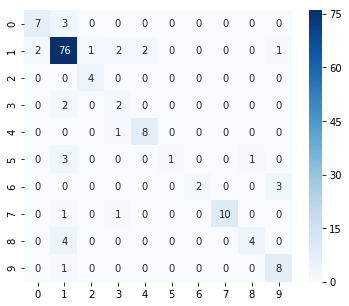

In [1009]:
fig, ax = plt.subplots(figsize=(6, 5));

sns.heatmap(
    data=confusion_matrix(y_true=y_test_red, y_pred=predictions),
    annot=True,
    cmap='Blues',
    ax=ax
);

In [1010]:
tsfresh_features[
    important_features.tolist()[:6] + ['cluster_label']
].groupby('cluster_label').describe()

variable      activity__change_quantiles__f_agg_"var"__isabs_False__qh_0.4__ql_0.2  \
                                                                             count   
cluster_label                                                                        
0                                                           37.0                     
1                                                          286.0                     
2                                                           19.0                     
3                                                           17.0                     
4                                                           23.0                     
5                                                           16.0                     
6                                                           18.0                     
7                                                           30.0                     
8                                                           22.0                     
9                                                           32.0                     

variable                                                               \
                       mean           std           min           25%   
cluster_label                                                           
0              8.628059e-03  3.462904e-03  1.605786e-03  6.169010e-03   
1              5.402317e-03  7.637367e-03  7.643268e-08  4.666706e-06   
2              8.855222e-03  2.754648e-03  4.002505e-03  6.676579e-03   
3              7.719543e-07  4.683994e-07  1.333092e-07  4.911658e-07   
4              3.131348e-07  1.588897e-07  1.277927e-07  1.895926e-07   
5              1.543510e-02  6.096784e-03  7.560004e-03  1.028245e-02   
6              1.648618e-02  4.561648e-03  7.588870e-03  1.404375e-02   
7              6.205953e-07  8.749747e-07  3.710479e-08  1.864055e-07   
8              1.157842e-02  3.252777e-03  6.630180e-03  8.981279e-03   
9              1.964406e-02  4.985132e-03  8.467743e-03  1.662890e-02   

variable                                                 \
                        50%           75%           max   
cluster_label                                             
0              8.357549e-03  1.036557e-02  1.679702e-02   
1              2.686289e-04  9.503831e-03  3.243312e-02   
2              8.989825e-03  1.052041e-02  1.362009e-02   
3              6.709641e-07  1.040238e-06  1.819368e-06   
4              2.680867e-07  3.682324e-07  8.163749e-07   
5              1.552708e-02  1.904375e-02  2.827774e-02   
6              1.641621e-02  1.871220e-02  2.542647e-02   
7              4.458265e-07  6.052172e-07  4.716931e-06   
8              1.071058e-02  1.457913e-02  1.695513e-02   
9              1.993974e-02  2.280746e-02  2.808763e-02   

variable      activity__change_quantiles__f_agg_"var"__isabs_False__qh_0.6__ql_0.0  \
                                                                             count   
cluster_label                                                                        
0                                                           37.0                     
1                                                          286.0                     
2                                                           19.0                     
3                                                           17.0                     
4                                                           23.0                     
5                                                           16.0                     
6                                                           18.0                     
7                                                           30.0                     
8                                                           22.0                     
9                                                           32.0                     

variable                                    

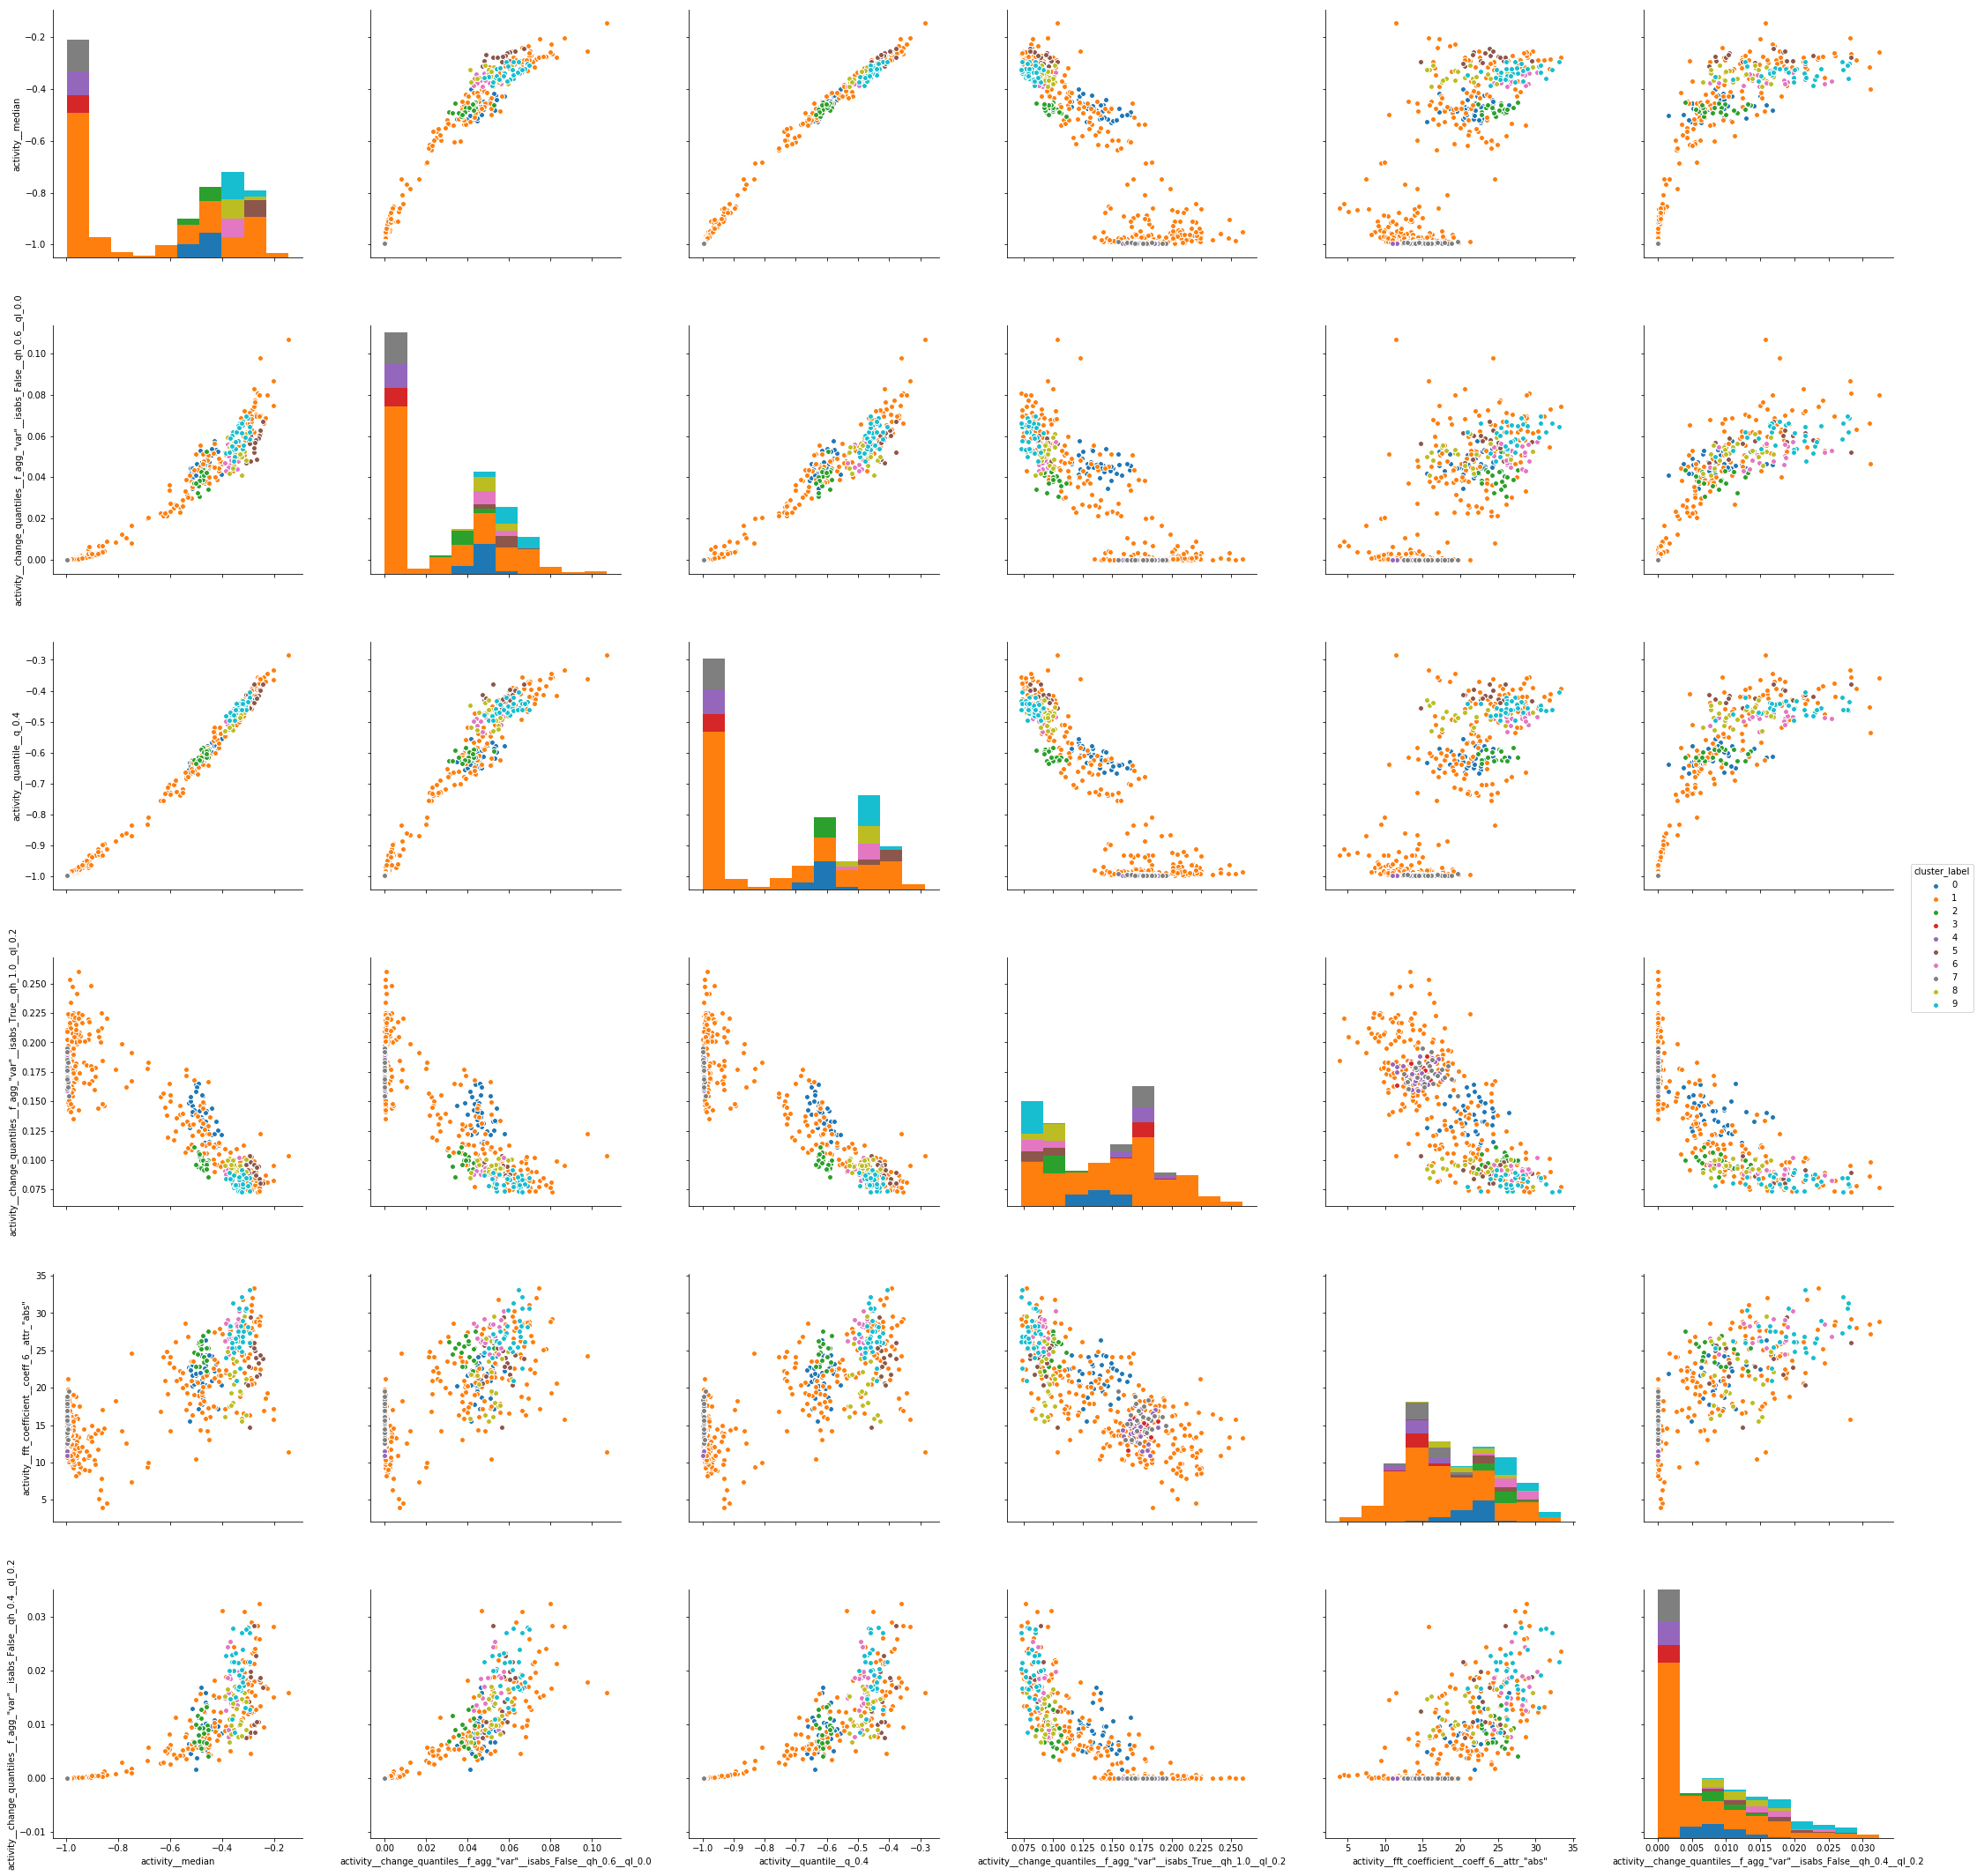

In [1011]:
sns.pairplot(
    data=tsfresh_features[
        important_features.tolist()[:6] + ['cluster_label']
    ],
    vars=important_features.tolist()[:6],
    hue='cluster_label',
    size=5
);

## Proximity matrix

In [1012]:
leaf_index_matrix = model_reduced.apply(tsfresh_features[important_features])

In [1013]:
def proximity(arr):
    return np.sum(arr == leaf_index_matrix, axis=1)

In [1014]:
proximity_matrix = np.apply_along_axis(
    func1d=proximity,
    axis=1,
    arr=leaf_index_matrix
)

In [1015]:
similarity_matrix = proximity_matrix/proximity_matrix.max()

In [1016]:
distance_matrix = 1 - similarity_matrix

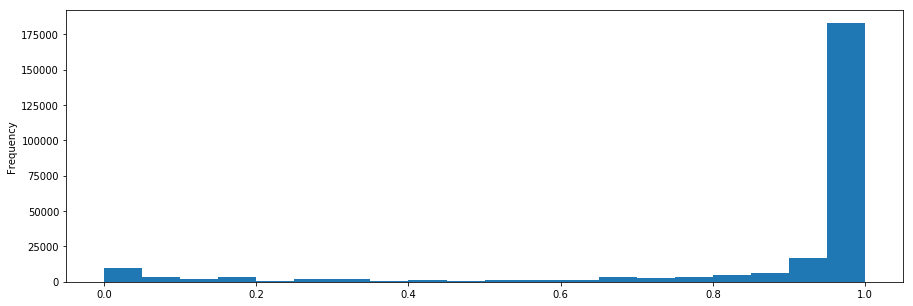

In [1017]:
pd.Series(distance_matrix.flatten()).plot(
    kind='hist',
    figsize=(15, 5),
    bins=20
);

In [1018]:
from skbio.stats.distance import mantel

# package reference here http://scikit-bio.org/docs/0.5.1/generated/generated/skbio.stats.distance.mantel.html

In [1019]:
mantel(
    x=distance_matrix,
    y=dtw_mtx[:n_series,:n_series],
    method='spearman',
    alternative='two-sided'
)

(0.47103063179944898, 0.001, 500)

### Graph based on distance matrix derived from proximity matrix of random forest with colors based on cluster labels

In [1020]:
def proximity_mtx_distance_function(x, y):
    # x and y must be one-dimensional numpy arrays
    # in our case they will each be one-dimensional, representing a point's index
    return distance_matrix[int(x[0]), int(y[0])]

In [1021]:
metric_pm = DistanceMetric.get_metric('pyfunc', func=proximity_mtx_distance_function)

In [1022]:
from sklearn.neighbors import NearestNeighbors

nnb_pm = NearestNeighbors(
    n_neighbors=30,
    metric=proximity_mtx_distance_function
)

nnb_pm.fit(X_nn.values.reshape(-1, 1))

NearestNeighbors(algorithm='auto', leaf_size=30,
         metric=<function proximity_mtx_distance_function at 0x1c3a34a510>,
         metric_params=None, n_jobs=1, n_neighbors=30, p=2, radius=1.0)

In [1023]:
def get_kgneighbors_indexes_pm(idx):
#     return nnb.kneighbors(dtw_mtx[[idx]])[1][0]
    return nnb_pm.kneighbors(X_nn[[idx]].values.reshape(-1, 1))[1][0]

In [1024]:
from functools import reduce

knn_edges_pm = reduce(lambda x, y: x+y, [
    [(idx, neighbor_idx.item()) for neighbor_idx in get_kgneighbors_indexes_pm(idx) if idx != neighbor_idx]
    for idx in range(len(distance_matrix))
])

# mutual k-neighbors graph
knn_edges_pm_both = [
    e for e in knn_edges_pm if (e[1], e[0]) in knn_edges_pm and e[0] < e[1]
]

G = nx.Graph()

G.add_nodes_from(list(range(len(distance_matrix))))

G.add_edges_from(knn_edges_pm_both)

nodes = [{'name': str(i), 'cluster': str(knn_clusters[i].item())} for i in G.nodes()]
links = [{'source': u[0], 'target': u[1]} for u in G.edges()]
with open('har_pm_distance_neighbors_graph_clusters.json', 'w') as f:
    json.dump(
        {'nodes': nodes, 'links': links},
        f,
        indent=4,
    )

In [1025]:
%%html
<div id="har_pm_distance_neighbors_graph_clusters"></div>
<style>
.node {stroke: #fff; stroke-width: 1.5px;}
.link {stroke: #999; stroke-opacity: .6;}
</style>

In [1026]:
%%javascript
// We load the d3.js library from the Web.
require.config({paths:
    {d3: "http://d3js.org/d3.v3.min"}});
require(["d3"], function(d3) {
  // The code in this block is executed when the
  // d3.js library has been loaded.

  // First, we specify the size of the canvas
  // containing the visualization (size of the
  // <div> element).
  var width = 800, height = 800;

  // We create a color scale.
  var color = d3.scale.category10();

  // We create a force-directed dynamic graph layout.
  var force = d3.layout.force()
    .charge(-20)
    .linkDistance(25)
    .size([width, height]);

  // In the <div> element, we create a <svg> graphic
  // that will contain our interactive visualization.
  var svg = d3.select("#har_pm_distance_neighbors_graph_clusters").select("svg")
  if (svg.empty()) {
    svg = d3.select("#har_pm_distance_neighbors_graph_clusters").append("svg")
          .attr("width", width)
          .attr("height", height);
  }

  // We load the JSON file.
  d3.json("har_pm_distance_neighbors_graph_clusters.json", function(error, graph) {
    // In this block, the file has been loaded
    // and the 'graph' object contains our graph.

    // We load the nodes and links in the
    // force-directed graph.
    force.nodes(graph.nodes)
      .links(graph.links)
      .start();

    // We create a <line> SVG element for each link
    // in the graph.
    var link = svg.selectAll(".link")
      .data(graph.links)
      .enter().append("line")
      .attr("class", "link");

    // We create a <circle> SVG element for each node
    // in the graph, and we specify a few attributes.
    var node = svg.selectAll(".node")
      .data(graph.nodes)
      .enter().append("circle")
      .attr("class", "node")
      .attr("r", 3)  // radius
      .style("fill", function(d) {
         // The node color depends on the club.
         return color(d.cluster);
      })
      .call(force.drag);

    // The name of each node is the node number.
    node.append("title")
        .text(function(d) { return d.name; });

    // We bind the positions of the SVG elements
    // to the positions of the dynamic force-directed
    // graph, at each time step.
    force.on("tick", function() {
      link.attr("x1", function(d){return d.source.x})
          .attr("y1", function(d){return d.source.y})
          .attr("x2", function(d){return d.target.x})
          .attr("y2", function(d){return d.target.y});

      node.attr("cx", function(d){return d.x})
          .attr("cy", function(d){return d.y});
    });
  });
});

<IPython.core.display.Javascript object>